# <center>**Milestone 2**<center>

## **Import**

In [1]:
import os
import json
import gc
import pickle
import sys
import random
import pandas as pd
import matplotlib.pyplot as plt
import math

from pathlib import Path
from tqdm import tqdm
from __future__ import annotations
from collections import defaultdict

from my_scanner import *
from my_parser import *
from my_matcher import *
from my_featureEngineering import *
from my_modeling import *
from my_evaluation import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NguyenAn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\NguyenAn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\NguyenAn\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\NguyenAn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\NguyenAn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## **Configuration**


In [2]:
RAW_ROOT = "../30-paper"
USING_SHA256_HASH = False

# 1. Output directory
OUTPUT_DIR = "23127453"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Configuration for caching
CACHE_DIR = ".cache"
os.makedirs(CACHE_DIR, exist_ok=True)
sys.setrecursionlimit(20000)

random.seed(42)

## **Dataset rescan**


In [3]:
scan_result = scan_dataset(RAW_ROOT)

for k, v in scan_result.items():
    print(k, v["status"], v["versions"])

2211-13747 NO_TEX []
2211-13748 READY ['2211-13748v1']
2211-13749 READY ['2211-13749v1']
2211-13750 READY ['2211-13750v1', '2211-13750v2']
2211-13751 READY ['2211-13751v1']
2211-13752 READY ['2211-13752v1']
2211-13753 READY ['2211-13753v1']
2211-13754 READY ['2211-13754v1']
2211-13755 READY ['2211-13755v1', '2211-13755v2']
2211-13756 READY ['2211-13756v1', '2211-13756v2']
2211-13757 READY ['2211-13757v1', '2211-13757v2']
2211-13758 READY ['2211-13758v1']
2211-13759 READY ['2211-13759v1', '2211-13759v2']
2211-13760 READY ['2211-13760v1', '2211-13760v2']
2211-13761 READY ['2211-13761v1']
2211-13762 READY ['2211-13762v1', '2211-13762v2']
2211-13763 READY ['2211-13763v1']
2211-13764 READY ['2211-13764v1']
2211-13765 READY ['2211-13765v1']
2211-13766 READY ['2211-13766v1', '2211-13766v2', '2211-13766v3']
2211-13767 READY ['2211-13767v1']
2211-13768 READY ['2211-13768v1', '2211-13768v2']
2211-13769 READY ['2211-13769v1', '2211-13769v2']
2211-13770 READY ['2211-13770v1']
2211-13771 READY ['22

## **Version-level Multi-file Resolver**


In [4]:
pub_results = []

ready_items = [
    (pub_id, info)
    for pub_id, info in scan_result.items()
    if info["status"] == "READY"
]

for pub_id, info in tqdm(ready_items, desc="Publications"):
    for version in info["versions"]:
        version_path = f"{RAW_ROOT}/{pub_id}/tex/{version}"

        result = resolve_version(
            publication_id=pub_id,
            version_name=version,
            version_path=version_path
        )

        pub_results.append(result)

# Xem kết quả
for r in pub_results:
    print(r["publication_id"], r["version"], r["used_tex_files"])


Publications: 100%|██████████| 94/94 [00:00<00:00, 195.10it/s]

2211-13748 2211-13748v1 ['weibo.tex']
2211-13749 2211-13749v1 ['On_projections_of_tailsvA.tex']
2211-13750 2211-13750v1 ['comparingsinglettestingschemes.tex']
2211-13750 2211-13750v2 ['comparingsinglettestingschemes4.tex']
2211-13751 2211-13751v1 ['Kane_et_al_JFM_v1.tex']
2211-13752 2211-13752v1 ['main.tex', 'macros.tex', '00_abstract.tex', '01_intro.tex', '02_related.tex', '03_method.tex', '04_results.tex', '05_conclusion.tex', '07_acc.tex', '06_appendix.tex']
2211-13753 2211-13753v1 ['0-title.tex']
2211-13754 2211-13754v1 ['main.tex']
2211-13755 2211-13755v1 ['main.tex']
2211-13755 2211-13755v2 ['main.tex']
2211-13756 2211-13756v1 ['main.tex']
2211-13756 2211-13756v2 ['main.tex']
2211-13757 2211-13757v1 ['main.tex']
2211-13757 2211-13757v2 ['main.tex']
2211-13758 2211-13758v1 ['main.tex']
2211-13759 2211-13759v1 ['main.tex']
2211-13759 2211-13759v2 ['main.tex']
2211-13760 2211-13760v1 ['main.tex']
2211-13760 2211-13760v2 ['main.tex']
2211-13761 2211-13761v1 ['main.tex']
2211-13762 22

## **LaTeX Hierarchy Parser**

We parsed each LaTeX version into a hierarchical tree structure. Sectioning commands were treated as internal nodes, while only sentences, tables, and figures were considered leaf nodes, strictly following the seminar constraints. No deduplication or identifier assignment was performed at this stage.


In [5]:
def save_tree_to_cache(pub_id: str, version: str, root: FileNode) -> str:
    """
    Serialize tree to disk and return cache path.
    Returns the cache file path for later retrieval.
    """
    cache_path = os.path.join(CACHE_DIR, f"{pub_id}_{version}.pkl")
    with open(cache_path, "wb") as f:
        pickle.dump(root, f, protocol=4)
    return cache_path

def load_tree_from_cache(cache_path: str) -> FileNode:
    """Load tree from cache file."""
    with open(cache_path, "rb") as f:
        return pickle.load(f)

In [6]:
parsed_versions = []


for version_info in tqdm(
    pub_results,
    desc="Parsing LaTeX versions",
    unit="version(s)"
):
    if version_info["status"] != "RESOLVED":
        continue

    version_path = (
        f"{RAW_ROOT}/"
        f"{version_info['publication_id']}/tex/"
        f"{version_info['version']}"
    )

    try:
        root_node = parse_tex_files(
            version_path=version_path,
            tex_files=version_info["used_tex_files"]
        )

        # Save to disk instead of keeping in memory
        cache_path = save_tree_to_cache(
            pub_id=version_info["publication_id"],
            version=version_info["version"],
            root=root_node
        )

        parsed_versions.append({
            "publication_id": version_info["publication_id"],
            "version": version_info["version"],
            "cache_path": cache_path,  # Store path, not tree
            "root": None  # Placeholder
        })

        # Explicitly free memory
        del root_node
        gc.collect()

    except Exception as e:
        print(
            f"[ERROR] {version_info['publication_id']} "
            f"{version_info['version']}: {e}"
        )

Parsing LaTeX versions: 100%|██████████| 140/140 [00:25<00:00,  5.57version(s)/s]


## **Deduplication & ID Assignment**

In [7]:
"""
STEP 3 - Deduplication & Merge trees per publication

Input:
    parsed_versions: list of {
        publication_id,
        version,
        root (hierarchy tree)
    }

Output:
    final_trees: dict[publication_id] -> merged root tree
"""

# Group trees by publication_id
pub_groups = defaultdict(list)
for item in parsed_versions:
    pub_groups[item["publication_id"]].append(item)

final_trees = {}

for pub_id, versions in tqdm(pub_groups.items(), desc="Deduplicating", unit="publication(s)"):
    if not versions:
        continue
        
    # Sort versions
    versions.sort(key=lambda x: int(x["version"].split("v")[-1]) if "v" in x["version"] else 0)

    # Load Base Tree
    base_info = versions[0]
    with open(base_info["cache_path"], "rb") as f:
        base_root = pickle.load(f)

    # Normalize Base
    fast_normalize_and_id(base_root, pub_id, base_info["version"])
    
    # Build Index
    content_index = build_content_index(base_root, USING_SHA256_HASH)

    # Merge subsequent versions
    for v_info in versions[1:]:
        with open(v_info["cache_path"], "rb") as f:
            root = pickle.load(f)

        # Normalize Source
        fast_normalize_and_id(root, pub_id, v_info["version"])
        
        # Deduplicate
        deduplicate_tree(root, content_index, USING_SHA256_HASH)
        
        # Explicit cleanup
        del root
    
    final_trees[pub_id] = base_root
    
    # Periodic GC to prevent memory fragmentation on large datasets
    if len(final_trees) % 50 == 0:
        gc.collect()

print(f"DONE: merged {len(final_trees)} publications")

Deduplicating: 100%|██████████| 94/94 [00:11<00:00,  8.22publication(s)/s]

DONE: merged 94 publications


In [8]:
# Kiểm tra nhanh
sample_pub = next(iter(final_trees))
root = final_trees[sample_pub]

print("Sample publication:", sample_pub)
print("Root node type:", root.node_type)
print("Number of children:", len(root.children))

Sample publication: 2211-13748
Root node type: document
Number of children: 16


## **Export to JSON**

In [9]:
"""
Export Structured Publication JSON

Input:
    final_trees: dict[publication_id] -> root_node

Output:
    Student ID/
        <pub_id>/
            <pub_id>.json
            metadata.json
            references.json
        ...
"""

# Serialization helper
def serialize_node(node):
    """Recursively serialize a node to dictionary."""
    return {
        "id": node.id,
        "type": node.node_type,
        "full_text": getattr(node, "full_text", ""),
        "children": [serialize_node(child) for child in node.children]
    }

# Export statistics
export_count = 0
missing_metadata = []
missing_references = []

for pub_id, root in tqdm(final_trees.items(), desc="Exporting JSON", unit="pub"):
    
    # Create publication subdirectory
    pub_output_dir = os.path.join(OUTPUT_DIR, pub_id)
    os.makedirs(pub_output_dir, exist_ok=True)
    
    # ===== 1. Export Content Tree (Parsed Hierarchy) =====
    content_json = {
        "publication_id": pub_id,
        "content_tree": serialize_node(root)
    }
    
    content_path = os.path.join(pub_output_dir, f"{pub_id}.json")
    with open(content_path, "w", encoding="utf-8") as f:
        json.dump(content_json, f, ensure_ascii=False, indent=2)
    
    # ===== 2. Copy Metadata (Original from Semantic Scholar) =====
    raw_metadata_path = os.path.join(RAW_ROOT, pub_id, "metadata.json")
    metadata_path = os.path.join(pub_output_dir, "metadata.json")
    
    if os.path.exists(raw_metadata_path):
        with open(raw_metadata_path, "r", encoding="utf-8") as f:
            metadata = json.load(f)
        with open(metadata_path, "w", encoding="utf-8") as f:
            json.dump(metadata, f, ensure_ascii=False, indent=2)
    else:
        missing_metadata.append(pub_id)
    
    # ===== 3. Copy References (Original from Semantic Scholar) =====
    raw_references_path = os.path.join(RAW_ROOT, pub_id, "references.json")
    references_path = os.path.join(pub_output_dir, "references.json")
    
    if os.path.exists(raw_references_path):
        with open(raw_references_path, "r", encoding="utf-8") as f:
            references = json.load(f)
        with open(references_path, "w", encoding="utf-8") as f:
            json.dump(references, f, ensure_ascii=False, indent=2)
    else:
        missing_references.append(pub_id)
    
    export_count += 1

print(f"Exported {export_count} publications to: {OUTPUT_DIR}")

if missing_metadata:
    print(f"\nWARNING: {len(missing_metadata)} publication(s) missing metadata.json")
    print(f"   {', '.join(missing_metadata[:5])}" + (" ..." if len(missing_metadata) > 5 else ""))

if missing_references:
    print(f"\nWARNING: {len(missing_references)} publication(s) missing references.json")
    print(f"   {', '.join(missing_references[:5])}" + (" ..." if len(missing_references) > 5 else ""))

Exporting JSON: 100%|██████████| 94/94 [00:00<00:00, 230.69pub/s]

Exported 94 publications to: 23127453


## **Extract references**

In [10]:
raw_references = {}
extract_errors = 0

for version_info in tqdm(pub_results, desc="Extracting references", unit="version"):
    
    if version_info.get("status") == "NO_TEX":
        continue

    pub_id = version_info["publication_id"]
    version = version_info["version"]
    
    version_path = f"{RAW_ROOT}/{pub_id}/tex/{version}"
    
    if not os.path.exists(version_path):
        continue

    try:
        all_files_in_dir = os.listdir(version_path)
        
        target_files = [
            f for f in all_files_in_dir 
            if f.lower().endswith(('.bib', '.bbl', '.tex'))
        ]
        
        references = extract_references_from_tex_files(
            version_path=version_path,
            tex_files=target_files 
        )
        
        if references:
            if pub_id not in raw_references:
                raw_references[pub_id] = []
            raw_references[pub_id].extend(references)
            
    except Exception as e:
        extract_errors += 1
        pass

deduplicated_references = {}
global_key_mapping = {} 

# Deduplicate references per publication
for pub_id, refs in raw_references.items():
    dedup_list, key_map = deduplicate_references_with_mapping(refs)
    
    deduplicated_references[pub_id] = dedup_list
    
    global_key_mapping.update(key_map)

# Assign Semantic IDs
global_used_ids = set()

for pub_id in deduplicated_references:
    for ref in deduplicated_references[pub_id]:
        ref['ref_id'] = generate_semantic_id(ref, global_used_ids)

count_pubs = len(deduplicated_references)
total_refs = sum(len(refs) for refs in deduplicated_references.values())

print(f"\nPublications found: {count_pubs}/{len(pub_results)}")
print(f"Total unique references: {total_refs}")

Extracting references:  11%|█▏        | 16/140 [00:00<00:00, 142.29version/s]

[INFO] Parsing .bib file: ../30-paper/2211-13748/tex/2211-13748v1\mybibliography.bib
[INFO] Parsing .bib file: ../30-paper/2211-13750/tex/2211-13750v1\comparingsinglettestingschemes.bib
[INFO] Parsing .bib file: ../30-paper/2211-13750/tex/2211-13750v2\comparingsinglettestingschemes4.bib
[INFO] Parsing .bib file: ../30-paper/2211-13751/tex/2211-13751v1\bibliography_v3.bib
[INFO] Parsing .bib file: ../30-paper/2211-13752/tex/2211-13752v1\egbib.bib
[INFO] Parsing .bib file: ../30-paper/2211-13754/tex/2211-13754v1\refs.bib
[WARN] Bibliography file not found: ../30-paper/2211-13755/tex/2211-13755v1\egbib.bib
[INFO] Parsing .bib file: ../30-paper/2211-13755/tex/2211-13755v2\egbib.bib
[INFO] Parsing .bib file: ../30-paper/2211-13757/tex/2211-13757v1\bib.bib
[INFO] Parsing .bib file: ../30-paper/2211-13757/tex/2211-13757v2\bib.bib
[WARN] Bibliography file not found: ../30-paper/2211-13758/tex/2211-13758v1\example.bib
[INFO] Parsing .bib file: ../30-paper/2211-13758/tex/2211-13758v1\bibliograph

Extracting references:  37%|███▋      | 52/140 [00:00<00:00, 114.61version/s]

[INFO] Parsing .bib file: ../30-paper/2211-13762/tex/2211-13762v1\egbib.bib
[INFO] Parsing .bib file: ../30-paper/2211-13762/tex/2211-13762v2\egbib.bib
[INFO] Parsing .bib file: ../30-paper/2211-13764/tex/2211-13764v1\biblio.bib
[WARN] Bibliography file not found: ../30-paper/2211-13765/tex/2211-13765v1\references.bib
[INFO] Parsing .bib file: ../30-paper/2211-13766/tex/2211-13766v1\apssamp.bib
[INFO] Parsing .bib file: ../30-paper/2211-13766/tex/2211-13766v2\apssamp.bib
[INFO] Parsing .bib file: ../30-paper/2211-13766/tex/2211-13766v3\apssamp.bib
[INFO] Parsing .bib file: ../30-paper/2211-13767/tex/2211-13767v1\references.bib
[INFO] Parsing .bib file: ../30-paper/2211-13768/tex/2211-13768v1\reference.bib
[INFO] Parsing .bib file: ../30-paper/2211-13768/tex/2211-13768v2\reference.bib
[WARN] Bibliography file not found: ../30-paper/2211-13769/tex/2211-13769v1\strings,refs.bib
[INFO] Parsing .bib file: ../30-paper/2211-13769/tex/2211-13769v1\egbib.bib
[WARN] Bibliography file not found: 

Extracting references:  68%|██████▊   | 95/140 [00:00<00:00, 169.96version/s]

[WARN] Bibliography file not found: ../30-paper/2211-13781/tex/2211-13781v1\new.bib
[INFO] Parsing .bib file: ../30-paper/2211-13785/tex/2211-13785v1\egbib.bib
[INFO] Parsing .bib file: ../30-paper/2211-13785/tex/2211-13785v2\egbib.bib
[INFO] Parsing .bib file: ../30-paper/2211-13785/tex/2211-13785v3\egbib.bib
[INFO] Parsing .bib file: ../30-paper/2211-13786/tex/2211-13786v1\references.bib
[WARN] Bibliography file not found: ../30-paper/2211-13787/tex/2211-13787v1\./IEEEabrv,./IEEEexample.bib
[INFO] Parsing .bib file: ../30-paper/2211-13787/tex/2211-13787v1\IoT.bib
[WARN] Bibliography file not found: ../30-paper/2211-13787/tex/2211-13787v2\./IEEEabrv,./IEEEexample.bib
[INFO] Parsing .bib file: ../30-paper/2211-13787/tex/2211-13787v2\IoT.bib
[WARN] Bibliography file not found: ../30-paper/2211-13788/tex/2211-13788v1\CameraCal.bib
[INFO] Parsing .bib file: ../30-paper/2211-13789/tex/2211-13789v1\example.bib
[INFO] Parsing .bib file: ../30-paper/2211-13789/tex/2211-13789v2\example.bib
[IN

Extracting references:  82%|████████▏ | 115/140 [00:01<00:00, 74.71version/s]

[INFO] Parsing .bib file: ../30-paper/2211-13823/tex/2211-13823v1\egbib.bib
[INFO] Parsing .bib file: ../30-paper/2211-13828/tex/2211-13828v1\sddir.bib
[INFO] Parsing .bib file: ../30-paper/2211-13829/tex/2211-13829v1\root.bib
[INFO] Parsing .bib file: ../30-paper/2211-13829/tex/2211-13829v2\root.bib
[INFO] Parsing .bib file: ../30-paper/2211-13830/tex/2211-13830v1\bib.bib
[INFO] Parsing .bib file: ../30-paper/2211-13831/tex/2211-13831v1\dSJT2022.bib
[WARN] Bibliography file not found: ../30-paper/2211-13832/tex/2211-13832v1\bibliography.bib
[INFO] Parsing .bib file: ../30-paper/2211-13832/tex/2211-13832v2\bibliography.bib
[INFO] Parsing .bib file: ../30-paper/2211-13833/tex/2211-13833v1\non-identical-JJ.bib
[WARN] Bibliography file not found: ../30-paper/2211-13834/tex/2211-13834v1\kappa.bib
[WARN] Bibliography file not found: ../30-paper/2211-13834/tex/2211-13834v2\kappa.bib
[INFO] Parsing .bib file: ../30-paper/2211-13836/tex/2211-13836v1\bibliography.bib
[INFO] Parsing .bib file: .

Extracting references:  92%|█████████▏| 129/140 [00:01<00:00, 57.47version/s]

[INFO] Parsing .bib file: ../30-paper/2211-13838/tex/2211-13838v2\main.bib
[INFO] Parsing .bib file: ../30-paper/2211-13838/tex/2211-13838v2\main.bib
[WARN] Bibliography file not found: ../30-paper/2211-13838/tex/2211-13838v2\yourbibfile.bib
[WARN] Bibliography file not found: ../30-paper/2211-13839/tex/2211-13839v1\ref.bib
[WARN] Bibliography file not found: ../30-paper/2211-13839/tex/2211-13839v2\ref.bib
[INFO] Parsing .bib file: ../30-paper/2211-13841/tex/2211-13841v1\references.bib
[WARN] Bibliography file not found: ../30-paper/2211-13842/tex/2211-13842v1\references.bib
[INFO] Parsing .bib file: ../30-paper/2211-13843/tex/2211-13843v1\Referencesfinal.bib
[INFO] Parsing .bib file: ../30-paper/2211-13843/tex/2211-13843v2\Referencesfinal.bib
[INFO] Parsing .bib file: ../30-paper/2211-13844/tex/2211-13844v1\egbib.bib


Extracting references: 100%|██████████| 140/140 [00:01<00:00, 74.13version/s]

[INFO] Parsing .bib file: ../30-paper/2211-13846/tex/2211-13846v1\refs.bib
[INFO] Parsing .bib file: ../30-paper/2211-13846/tex/2211-13846v2\root.bib

Publications found: 77/140
Total unique references: 6525


## **Reference Cleaning**

Clean and normalize BibTeX and arXiv references for matching.

In [11]:
cleaned_bibtex = {}

for pub_id in tqdm(deduplicated_references.keys(), desc="Cleaning BibTeX", unit="pub"):
    cleaned_entries = []
    for ref in deduplicated_references[pub_id]:
        try:
            cleaned_ref = clean_bibtex_entry(ref)
            cleaned_ref['ref_id'] = ref.get('ref_id', '')
            cleaned_ref['key'] = ref.get('key', '')
            cleaned_ref['all_keys'] = ref.get('all_keys', [])
            
            cleaned_entries.append(cleaned_ref)
        except Exception as e:
            continue
            
    cleaned_bibtex[pub_id] = cleaned_entries

cleaned_arxiv = {}

for pub_id in tqdm(cleaned_bibtex.keys(), desc="Loading & Cleaning arXiv Truth", unit="pub"):
    ref_json_path = os.path.join(RAW_ROOT, pub_id, "references.json")
    
    if os.path.exists(ref_json_path):
        try:
            with open(ref_json_path, 'r', encoding='utf-8') as f:
                arxiv_raw = json.load(f)
            
            cleaned_entries = []
            for arxiv_id, meta in arxiv_raw.items():
                meta['arxiv_id'] = arxiv_id 
                cleaned_ref = clean_arxiv_reference(meta)
                cleaned_entries.append(cleaned_ref)
            
            cleaned_arxiv[pub_id] = cleaned_entries
        except Exception as e:
            print(f"[WARN] Error loading references.json for {pub_id}: {e}")
            cleaned_arxiv[pub_id] = []
    else:
        cleaned_arxiv[pub_id] = []

# Summary
total_bib = sum(len(x) for x in cleaned_bibtex.values())
total_arxiv = sum(len(x) for x in cleaned_arxiv.values())
print(f"\nDONE: {total_bib} cleaned BibTeX entries vs {total_arxiv} cleaned arXiv entries.")

Loading & Cleaning arXiv Truth: 100%|██████████| 77/77 [00:00<00:00, 135.86pub/s]


DONE: 6525 cleaned BibTeX entries vs 1484 cleaned arXiv entries.


## **Labeling & Dataset Construction**

Generate labeled dataset using heuristic matching and manual ground truth.

### **Manual Labeling**

In [12]:
# MANUAL PAIRS
FIXED_MANUAL_DATA = {
    "2211-13768": {
        "2008MNRAS.391.1685S": "0809-0898",
        "2014MNRAS.441.3359D": "1402-7073",
        "2021MNRAS.503..920C": "2007-02958",
        "2022arXiv220405981K": "2204-05981",
        "Agrawal11611004611": "1610-04611"
    },
    "2211-13757": {
        "3DiM": "2210-04628",
        "acronym": "2011-09584",
        "attention": "1706-03762",
        "autosdf": "2203-09516",
        "cascaded-point-completion": "2004-03327"
    },
    "2211-13767": {
        "Bapat2018": "1812-02746",
        "Bittel_2021": "2101-07267",
        "Brady2021": "2107-01218",
        "Crosson_2021": "2008-09913",
        "Farhi2016": "1602-07674"
    },
    "2211-13755": {
        "AANet": "2004-09548",
        "ACVNet": "2203-02146",
        "AcfNet": "1909-03751",
        "AnyNet": "1810-11408",
        "BI3D": "2005-07274"
    },
    "2211-13766": {
        "BittencourtDamping2022": "2301-11920",
        "Marius_Schrodinger_2022": "2211-00449",
        "asjad2022magnon": "2203-10767",
        "bourcin2022strong": "2209-14643",
        "chan2011laser": "1106-3614"
    }
}

manual_pairs = []
for pub_id, labels in FIXED_MANUAL_DATA.items():
    arxiv_pool = cleaned_arxiv.get(pub_id, [])
    bib_pool = cleaned_bibtex.get(pub_id, [])
    
    if not arxiv_pool or not bib_pool: continue
    
    for bib_key, target_id in labels.items():
        bib_entry = next((e for e in bib_pool if e.get('key') == bib_key), None)
        target_arxiv = next((e for e in arxiv_pool if e.get('arxiv_id') == target_id), None)
        
        if bib_entry and target_arxiv:
            # Base record structure
            base = {
                'pub_id': pub_id,
                'bib_key': bib_key,
                'all_keys': bib_entry.get('all_keys', []),
                'bib_ref_id': bib_entry.get('ref_id'), 
                'bib_title_clean': bib_entry.get('normalized_title'),
                'bib_authors_clean': ", ".join(bib_entry.get('normalized_authors', [])),
                'bib_author_tokens': str(bib_entry.get('author_tokens', [])),
                'bib_year': bib_entry.get('normalized_year'),
                'source': 'manual'
            }
            
            # Positive Pair
            pos = base.copy()
            pos.update({
                'candidate_arxiv_id': target_id,
                'candidate_title_clean': target_arxiv.get('normalized_title'),
                'candidate_authors_clean': ", ".join(target_arxiv.get('normalized_authors', [])),
                'candidate_author_tokens': str(target_arxiv.get('author_tokens', [])),
                'candidate_year': target_arxiv.get('normalized_year'),
                'pair_type': 'positive_manual', 'label': 1
            })
            manual_pairs.append(pos)
            
            # Negative Pairs (Exhaustive)
            for neg in [a for a in arxiv_pool if a['arxiv_id'] != target_id]:
                neg_row = base.copy()
                neg_row.update({
                    'candidate_arxiv_id': neg['arxiv_id'],
                    'candidate_title_clean': neg.get('normalized_title'),
                    'candidate_authors_clean': ", ".join(neg.get('normalized_authors', [])),
                    'candidate_author_tokens': str(neg.get('author_tokens', [])),
                    'candidate_year': neg.get('normalized_year'),
                    'pair_type': 'negative_manual', 'label': 0
                })
                manual_pairs.append(neg_row)

print(f"Generated {len(manual_pairs)} manual pairs.")

Generated 1635 manual pairs.


### **Automatic Labeling**

In [13]:
# Configuration for automatic labeling
POSITIVE_THRESHOLD = 0.4
TARGET_PERCENTAGE = 0.10  # 10% of publications

# Get list publications without manual labeling data
auto_pub_ids = [p for p in cleaned_bibtex.keys() if p not in FIXED_MANUAL_DATA]

# Calculate target number of publications
target_num_pubs = math.ceil(len(auto_pub_ids) * TARGET_PERCENTAGE)

print(f"Total auto publications: {len(auto_pub_ids)}")
print(f"Target 10%: {target_num_pubs} publications")
print(f"\nScanning all publications to find valid ones...")

Total auto publications: 72
Target 10%: 8 publications

Scanning all publications to find valid ones...


In [14]:
# Scan ALL publications first, then select valid ones

all_valid_entries = {}  # {(pub_id, bib_key): {'bib': ..., 'arxiv_scores': [...]}}
valid_pub_ids = set()   # Track publications with at least 1 valid entry

for pub_id in tqdm(auto_pub_ids, desc="Scanning all publications"):
    arxiv_pool = cleaned_arxiv.get(pub_id, [])
    bib_pool = cleaned_bibtex.get(pub_id, [])
    
    # Skip if missing data
    if not arxiv_pool or not bib_pool:
        continue
    
    for bib in bib_pool:
        bib_key = bib.get('key')
        arxiv_scores = []
        
        # Calculate score with ALL arxiv in pool
        for arxiv in arxiv_pool:
            match = find_best_match(bib, [arxiv], threshold=0.0)
            
            if match:
                _, score, _ = match
            else:
                score = 0.0
            
            arxiv_scores.append((arxiv, score))
        
        # Check if this entry has at least 1 positive
        has_positive = any(score > POSITIVE_THRESHOLD for _, score in arxiv_scores)
        
        if has_positive:
            all_valid_entries[(pub_id, bib_key)] = {
                'bib': bib,
                'arxiv_pool': arxiv_pool,
                'arxiv_scores': arxiv_scores
            }
            valid_pub_ids.add(pub_id)

print(f"\nTotal valid publications (with positive matches): {len(valid_pub_ids)}")
print(f"Total valid entries: {len(all_valid_entries)}")

Scanning all publications: 100%|██████████| 72/72 [00:12<00:00,  5.62it/s]


Total valid publications (with positive matches): 58
Total valid entries: 1401


In [15]:
# Select exactly target_num_pubs from valid publications
valid_pub_list = list(valid_pub_ids)

# Use random sampling for unbiased selection
random.shuffle(valid_pub_list)
selected_pub_ids = valid_pub_list[:target_num_pubs]

# Filter entries to only include selected publications
filtered_entries = {
    key: data 
    for key, data in all_valid_entries.items() 
    if key[0] in selected_pub_ids
}

print(f"Target publications: {target_num_pubs}")
print(f"Available valid publications: {len(valid_pub_ids)}")
print(f"Selected publications: {len(selected_pub_ids)}")
print(f"Filtered entries: {len(filtered_entries)}")
print(f"\nSelected pub_ids: {selected_pub_ids}")

Target publications: 8
Available valid publications: 58
Selected publications: 8
Filtered entries: 136

Selected pub_ids: ['2211-13803', '2211-13786', '2211-13831', '2211-13821', '2211-13764', '2211-13770', '2211-13835', '2211-13832']


In [16]:
# Build automatic pairs

automatic_pairs = []

for (pub_id, bib_key), data in tqdm(filtered_entries.items(), desc="Building Auto Dataset"):
    bib = data['bib']
    arxiv_pool = data['arxiv_pool']
    
    # Base record for this entry
    base = {
        'pub_id': pub_id,
        'bib_key': bib.get('key'),
        'all_keys': bib.get('all_keys', []),
        'bib_ref_id': bib.get('ref_id'), 
        'bib_title_clean': bib.get('normalized_title'),
        'bib_authors_clean': ", ".join(bib.get('normalized_authors', [])),
        'bib_author_tokens': str(bib.get('author_tokens', [])), 
        'bib_year': bib.get('normalized_year'),
        'source': 'automatic'
    }
    
    # Generate pairs based on scores
    for arxiv, score in data['arxiv_scores']:
        pair = base.copy()
        pair.update({
            'candidate_arxiv_id': arxiv['arxiv_id'],
            'candidate_title_clean': arxiv.get('normalized_title'),
            'candidate_authors_clean': ", ".join(arxiv.get('normalized_authors', [])),
            'candidate_author_tokens': str(arxiv.get('author_tokens', [])),
            'candidate_year': arxiv.get('normalized_year'),
            'pair_type': 'positive_auto' if score > 0.4 else 'negative_auto',
            'label': 1 if score > 0.4 else 0
        })
        automatic_pairs.append(pair)

print(f"\nGenerated {len(automatic_pairs)} automatic pairs.")

Building Auto Dataset: 100%|██████████| 136/136 [00:00<00:00, 333.36it/s]


Generated 5112 automatic pairs.


In [17]:
# Summary
df_auto = pd.DataFrame(automatic_pairs)
num_positives = len(df_auto[df_auto['label'] == 1])
num_negatives = len(df_auto[df_auto['label'] == 0])
num_entries = df_auto['bib_key'].nunique()

print(f"\n{'='*60}")
print(f"Automatic Labeling Summary")
print(f"{'='*60}")
print(f"  Publications labeled: {len(selected_pub_ids)}")
print(f"  BibTeX entries labeled: {num_entries}")
print(f"  Total pairs: {len(automatic_pairs)}")
print(f"  Positive pairs: {num_positives}")
print(f"  Negative pairs: {num_negatives}")
print(f"  Ratio (pos:neg): 1:{num_negatives/max(1, num_positives):.1f}")
print(f"{'='*60}")


Automatic Labeling Summary
  Publications labeled: 8
  BibTeX entries labeled: 136
  Total pairs: 5112
  Positive pairs: 189
  Negative pairs: 4923
  Ratio (pos:neg): 1:26.0


## **Export CSV**

Export labeled dataset for modeling.

In [18]:
final_df = pd.DataFrame(manual_pairs + automatic_pairs)

cols = [
    'pub_id', 'bib_key', 'all_keys', 'bib_ref_id', 
    'bib_title_clean', 'bib_authors_clean', 'bib_author_tokens', 'bib_year',
    'candidate_arxiv_id', 
    'candidate_title_clean', 'candidate_authors_clean', 'candidate_author_tokens', 'candidate_year',
    'source', 'pair_type', 'label'
]

for c in cols: 
    if c not in final_df.columns: final_df[c] = None

labeled_df = final_df[cols]

print(f"Positives: {len(labeled_df[labeled_df['label']==1])}")
print(f"Negatives: {len(labeled_df[labeled_df['label']==0])}")
print(f"Total pairs: {len(labeled_df)}")

csv_output_path = "../src/labeled_dataset.csv"
labeled_df.to_csv(csv_output_path, index=False, encoding='utf-8')

print(f"Saved labeled dataset to: {csv_output_path}")

Positives: 214
Negatives: 6533
Total pairs: 6747
Saved labeled dataset to: ../src/labeled_dataset.csv


## **Feature Engineering**

Create features from labeled dataset.

In [20]:
# Load labeled dataset if not already in memory
if final_df is None:
    print("final_df is None, loading from CSV...")
    labeled_path = "../src/labeled_dataset.csv"
    if not labeled_path.exists():
        raise FileNotFoundError(f"File not found: {labeled_path}. Run Notebook 02 first!")

    final_df = pd.read_csv(labeled_path)

# Apply feature engineering
df_features = feature_engineering(final_df)

# Save featured dataset
featured_path = "../src/featured_dataset.csv"
df_features.to_csv(featured_path, index=False)

# Summary
print(f"{'='*60}")
print(f"Feature Engineering Complete")
print(f"{'='*60}")
print(f"  Total samples: {len(df_features)}")
print(f"  Features created: {len([c for c in df_features.columns if c not in ['label', 'pub_id', 'bib_key', 'candidate_arxiv_id', 'source']])}")
# Check for NaN/Inf
print(f"  NaN values: {df_features.isna().sum().sum()}")
print(f"  Inf values: {np.isinf(df_features.select_dtypes(include=[np.number])).sum().sum()}")
print(f"  Saved to: {featured_path}")
print(f"{'='*60}")

# Show feature columns
print("\n Feature columns:")
for col in df_features.columns:
    print(f"   - {col}")

df_features.head()

Feature Engineering Complete
  Total samples: 6747
  Features created: 5
  NaN values: 0
  Inf values: 0
  Saved to: ../src/featured_dataset.csv

 Feature columns:
   - label
   - pub_id
   - bib_key
   - candidate_arxiv_id
   - source
   - Title_Soft_Jaccard
   - Title_Length_Diff
   - Author_Overlap_Score
   - Author_Levenshtein_Ratio
   - Year_Diff


,label,pub_id,bib_key,candidate_arxiv_id,source,Title_Soft_Jaccard,Title_Length_Diff,Author_Overlap_Score,Author_Levenshtein_Ratio,Year_Diff
0,1,2211-13768,2008MNRAS.391.1685S,0809-0898,manual,1.000000,0,0.615385,0.883570,0.0
1,0,2211-13768,2008MNRAS.391.1685S,2210-01131,manual,0.076923,16,0.076923,0.169553,14.0
2,0,2211-13768,2008MNRAS.391.1685S,2209-13393,manual,0.000000,24,0.000000,0.135608,14.0
3,0,2211-13768,2008MNRAS.391.1685S,2209-07539,manual,0.000000,19,0.071429,0.239480,14.0
4,0,2211-13768,2008MNRAS.391.1685S,2209-06834,manual,0.000000,30,0.000000,0.084656,14.0


## **Train/Valid/Test Split**

Split dataset into Train, Validation, and Test sets.

In [21]:
# Get paper IDs for manual and automatic sources
manual_pub_ids = df_features[df_features['source'] == 'manual']['pub_id'].unique().tolist()
auto_pub_ids = df_features[df_features['source'] == 'automatic']['pub_id'].unique().tolist()

print(f"Manual labeled publications: {len(manual_pub_ids)}")
print(f"Automatic labeled publications: {len(auto_pub_ids)}")

# Split data
df_train, df_val, df_test = split_data(df_features, manual_pub_ids=manual_pub_ids, auto_pub_ids=auto_pub_ids)

train_path = "../src/train_dataset.csv"
val_path = "../src/val_dataset.csv"
test_path = "../src/test_dataset.csv"
df_train.to_csv(train_path, index=False)
df_val.to_csv(val_path, index=False)
df_test.to_csv(test_path, index=False)

Manual labeled publications: 5
Automatic labeled publications: 8
Split summary:
  Train: 3537 rows, 9 publications
  Valid: 300 rows, 2 publications
  Test:  2910 rows, 2 publications


## **Model Training**

Training model with Negative Sampling to handle data imbalance.

In [32]:
print(f"\n{'='*60}")
print(f"Starting Model Training")
print(f"{'='*60}")

USE_NEGATIVE_SAMPLING = True

K_NEGATIVES = 15

HARD_RATIO = 0.6

# Define feature columns
FEATURE_COLS = [
    # Title features
    "Title_Soft_Jaccard",
    "Title_Length_Diff",
    # Author features
    "Author_Overlap_Score",
    "Author_Levenshtein_Ratio",
    # Year features
    "Year_Diff"
]

# Get available features in the DataFrame
available_features = [f for f in FEATURE_COLS if f in df_train.columns]
print(f"Using {len(available_features)} features: {available_features}")

TARGET = "label"

# Check data imbalance before sampling
print(f"\nData imbalance BEFORE sampling:")
print(f"  Positives: {len(df_train[df_train[TARGET]==1])}")
print(f"  Negatives: {len(df_train[df_train[TARGET]==0])}")
print(f"  Ratio (pos:neg): 1:{len(df_train[df_train[TARGET]==0])/max(1, len(df_train[df_train[TARGET]==1])):.1f}")

# Train with configured negative sampling
model = train_ranker(
    df_train, 
    df_val, 
    features=available_features, 
    target=TARGET,
    use_negative_sampling=USE_NEGATIVE_SAMPLING,
    k_negatives=K_NEGATIVES,
    hard_ratio=HARD_RATIO
)

# Save model
model_path = save_model(model, "../src", filename="xgb_ranker.joblib")

print(f"\n{'='*60}")
print(f"Training Complete")
print(f"{'='*60}")


Starting Model Training
Using 5 features: ['Title_Soft_Jaccard', 'Title_Length_Diff', 'Author_Overlap_Score', 'Author_Levenshtein_Ratio', 'Year_Diff']

Data imbalance BEFORE sampling:
  Positives: 120
  Negatives: 3417
  Ratio (pos:neg): 1:28.5

Applying negative sampling to training data...

Negative Sampling Summary:
  Original: 3537 rows
  Sampled:  1503 rows
  Reduction: 57.5%
  Positives: 120
  Negatives: 1383
  Ratio (pos:neg): 1:11.5
Best iteration: 0
Best score: 1.0
Model saved to: ../src\xgb_ranker.joblib

Training Complete



Feature Importance:


,feature,importance
2,Author_Overlap_Score,0.587098
4,Year_Diff,0.274140
3,Author_Levenshtein_Ratio,0.075007
0,Title_Soft_Jaccard,0.033213
1,Title_Length_Diff,0.030542


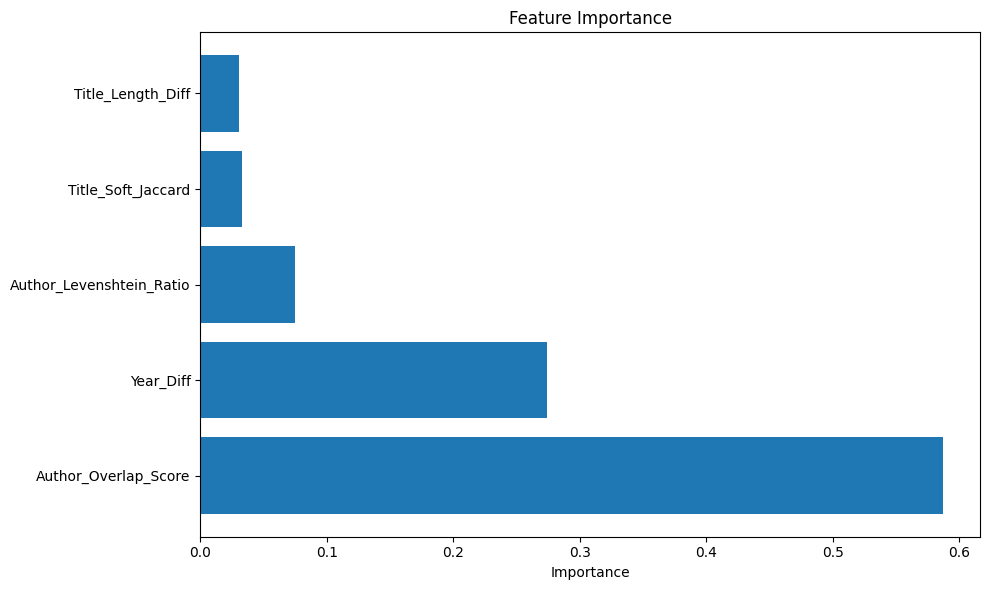

In [33]:
# Feature Importance
print("\nFeature Importance:")
importance_df = get_feature_importance(model, available_features)
display(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

## **Prediction**

Predict rankings.

In [34]:
# Predict on test set (returns nested dict: {pub_id: {bib_key: [candidates]}})
print("Predicting on test set...")
test_predictions = predict_rankings(model, df_test, available_features, top_k=5)

# Predict on validation set
print("Predicting on validation set...")
val_predictions = predict_rankings(model, df_val, available_features, top_k=5)

# Predict on train set
print("Predicting on train set...")
train_predictions = predict_rankings(model, df_train, available_features, top_k=5)

test_groundtruth = extract_groundtruth(df_test)
val_groundtruth = extract_groundtruth(df_val)
train_groundtruth = extract_groundtruth(df_train)

print(f"\nGroundtruth extracted:")
print(f"  Test: {sum(len(v) for v in test_groundtruth.values())} references across {len(test_groundtruth)} publications")
print(f"  Valid: {sum(len(v) for v in val_groundtruth.values())} references across {len(val_groundtruth)} publications")
print(f"  Train: {sum(len(v) for v in train_groundtruth.values())} references across {len(train_groundtruth)} publications")

Predicting on test set...
Predicting on validation set...
Predicting on train set...

Groundtruth extracted:
  Test: 55 references across 2 publications
  Valid: 9 references across 2 publications
  Train: 97 references across 9 publications


## **Evaluation**

Evaluate using MRR metric.

In [35]:
# Flatten for evaluation
test_predictions_flat = flatten_nested_dict(test_predictions)
test_groundtruth_flat = flatten_groundtruth(test_groundtruth)

val_predictions_flat = flatten_nested_dict(val_predictions)
val_groundtruth_flat = flatten_groundtruth(val_groundtruth)

train_predictions_flat = flatten_nested_dict(train_predictions)
train_groundtruth_flat = flatten_groundtruth(train_groundtruth)

# Evaluate on test set
print("="*70)
print("Evaluating on TEST set")
print("="*70)
test_mrr = calculate_mrr(test_predictions_flat, test_groundtruth_flat)
print(f"  Test MRR: {test_mrr:.4f}")

Evaluating on TEST set
  Test MRR: 0.7439


## **Export pred.json files**
Export pred.json files for all publications in the dataset.

In [36]:
def get_partition(pub_id, test_pub_ids, val_pub_ids, train_pub_ids):
    """Determine which partition a publication belongs to"""
    if pub_id in test_pub_ids:
        return "test"
    elif pub_id in val_pub_ids:
        return "valid"
    elif pub_id in train_pub_ids:
        return "train"
    else:
        return "unknown"

In [37]:
# Load all data (Train, Valid and Test set) to predict
df_all = pd.read_csv("../src/featured_dataset.csv")

# Get pub_ids for each partition
train_pub_ids = set(df_train['pub_id'].unique())
val_pub_ids = set(df_val['pub_id'].unique())
test_pub_ids = set(df_test['pub_id'].unique())

# Predict rankings for ALL data (returns nested dict: {pub_id: {bib_key: [candidates]}})
print("Predicting on all data (Train, Valid and Test set)...")
all_predictions = predict_rankings(model, df_all, available_features, top_k=5)

# Extract groundtruth (nested dict: {pub_id: {bib_key: arxiv_id}})
all_groundtruth = extract_groundtruth(df_all)

# Export pred.json for each publication
exported = {"train": 0, "valid": 0, "test": 0, "unknown": 0}
for pub_id, predictions in all_predictions.items():
    pub_folder = Path(OUTPUT_DIR + "/" + pub_id)
    pub_folder.mkdir(parents=True, exist_ok=True)
    
    # Determine correct partition for this publication
    partition = get_partition(pub_id, test_pub_ids, val_pub_ids, train_pub_ids)
    
    # Build pred.json
    pred_json = {
        "partition": partition,
        "groundtruth": all_groundtruth.get(pub_id, {}),
        "prediction": predictions
    }
    
    # Export to file
    output_file = pub_folder / "pred.json"
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(pred_json, f, indent=2, ensure_ascii=False)
    
    exported[partition] += 1

print(f"\n{'='*60}")
print(f"Export Complete")
print(f"{'='*60}")
print(f"  pred.json files exported:")
print(f"    - Train: {exported['train']}")
print(f"    - Valid: {exported['valid']}")
print(f"    - Test:  {exported['test']}")
print(f"  Output folder: {OUTPUT_DIR}/")
print(f"{'='*60}")

Predicting on all data (Train, Valid and Test set)...

Export Complete
  pred.json files exported:
    - Train: 9
    - Valid: 2
    - Test:  2
  Output folder: 23127453/
